In [1]:
from grcore.coco.dataset import CocoDataset
import pandas as pd
import random
import matplotlib.pyplot as plt
from collections import Counter
from fridgecore.coco import FridgeDataset
from plotutils import get_params, set_style, to_defaults, tex_escape, save_fig, gen_img_grid, cmap, colors, cmap, title_case
import seaborn as sns
from dhop.dataset import Parts2WholesDataset
from rich.jupyter import print
from common import *

In [2]:
%pprint

Pretty printing has been turned OFF


In [3]:
supercats = ["person"]
ttype = "val"
additional = "_subset"

## Coco dataset

In [4]:
# Import dataset
wholes_path = f"/data/dataset/pascal/pascalparts_person/annotations/{ttype}_wholes{additional}.json"
parts_path = f"/data/dataset/pascal/pascalparts_person/annotations/{ttype}_parts{additional}.json"
dset = FridgeDataset(CocoDataset(wholes_path))
pdset = FridgeDataset(CocoDataset(parts_path))
catdf = pd.DataFrame.from_dict(dset.cats.values())

loading annotations into memory...
Loading json: /data/dataset/pascal/pascalparts_person/annotations/val_wholes_subset.json
Done 0.21s
creating index...
index created!
loading annotations into memory...
Loading json: /data/dataset/pascal/pascalparts_person/annotations/val_parts_subset.json
Done 0.02s
creating index...
index created!


### Categories

In [5]:
# Common attributes
print(f"Root path: {dset.root_path}")
print(f"gt path: {dset.gt_path}")
catdf

Root path: /data/dataset/pascal/pascalparts_person

gt path: /data/dataset/pascal/pascalparts_person/annotations/val_wholes_subset.json

,id,name,supercategory,is_whole,has_parts
0,1,person,person,True,True
1,2,head,person,False,False
2,3,torso,person,False,False
3,4,larm,person,False,False
4,5,rarm,person,False,False
5,6,lleg,person,False,False
6,7,rleg,person,False,False


In [6]:
# If categories are equal
if pdset:
    check_equal_wp(dset, pdset, "cats")

True

### Annotations

In [7]:
check_catids_in_anns(dset, "wholes")
check_catids_in_anns(pdset, "parts")

wholes True

parts True

In [8]:
check_imgids_in_anns(dset, "wholes")
check_imgids_in_anns(pdset, "parts")

Wholes True

Parts True

#### Number of occluded annotations

In [9]:
check_ocln_anns(dset)


all:Counter({1: 148})

ocln:Counter()

non-ocln: Counter({1: 148})

#### Number of instances on images

In [10]:
# Number of instances on images
for catid, cat in dset.wholecats.items():
    all_annids = Counter()
    imgids = dset.get_imgids([catid])
    for imgid in imgids:
        annids = dset.get_annids([catid], [imgid])
        all_annids.update([len(annids)])
    print(f"{cat['name']}:{all_annids}")

person:Counter({1: 76, 2: 12, 3: 5, 4: 4, 6: 2, 5: 1})

#### Check if wholes and parts are mixed

In [11]:
# Check if wholes and parts are mixed
for catid, cat in pdset.wholecats.items():
    annids = pdset.get_annids([catid])
    print(f"{len(annids)} {cat['name']} wholes in part dataset")

0 person wholes in part dataset

#### Object size

In [12]:
def extract_data(dset, anninfos):
    data = {"catid":[], "cat":[], "supercat":[], "area":[], "ar":[]}
    for anninfo in anninfos:
        if not anninfo.get("is_occluded"):
            data["catid"].append(anninfo['category_id'])
            data["area"].append(anninfo['area'])
            bbox = anninfo["bbox"]
            catinfo = dset.load_catinfos([data["catid"][-1]])[0]
            data["cat"].append(catinfo["name"])
            data["supercat"].append(catinfo["supercategory"])
            data["ar"].append(bbox[2]/bbox[3])
    return data

# wholes
gt_catids = dset.wholecats.keys()
gt_annids = dset.get_annids(gt_catids)
gt_anns = dset.load_anninfos(gt_annids)
data = extract_data(dset, gt_anns)

# parts
dt_catids = pdset.partcats.keys()
dt_annids = pdset.get_annids(dt_catids)
dt_anns = pdset.load_anninfos(dt_annids)
dt_data = extract_data(pdset, dt_anns)

# To dataframe
data.update(dt_data)
df = pd.DataFrame.from_dict(data)
df["selected"] = df["area"].apply(lambda x: x>=100)
df = df.sort_values(["catid"])

In [13]:
df

,catid,cat,supercat,area,ar,selected
163,2,head,person,7984,0.836207,True
355,2,head,person,209,1.000000,True
410,2,head,person,3370,0.802632,True
610,2,head,person,432,0.892857,True
706,2,head,person,549,0.965517,True
...,...,...,...,...,...,...
545,7,rleg,person,716,0.433962,True
155,7,rleg,person,260,0.483871,True
336,7,rleg,person,52,0.434783,False
549,7,rleg,person,1339,0.597015,True


to_defaults()

figwidth = 252 #pt
fs = 7 #pt
f = "cm"
ff = "serif"
params = get_params("pdf", figwidth, "pt", ar="golden", f=f, fs=fs, ff=ff, show_dpi=300)
set_style("paper", "ticks", params)
sns.set_palette("colorblind")

plt.figure()
g = sns.catplot(x="area", y="cat", hue="supercat", data=df, kind="box")

# Add vertical area threshold line
plt.axvline(x=100, color=colors[3])
ax = plt.gca()
ax.text(100-20,6, "area threshold", color=colors[3], ha="center", rotation="vertical")

g.set(xscale="log")
g.legend.set_title("Supercategory")
plt.title("Area Distribution per Category over Train Images")
plt.xlabel("Area")
plt.ylabel("Class")
plt.xlim([10,1000])
plt.show()

### Image count

In [14]:
print(f"{ttype}/wholes: {len(dset)}")
print(f"{ttype}/parts: {len(pdset)}")

val/wholes: 100

val/parts: 100

### Show random images

################################################################################

imgid: 24

number of anns: 1

################################################################################

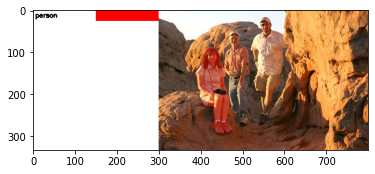

In [15]:
imgid = show_rand_img(dset, "person")

################################################################################

imgid: 24

number of anns: 6

################################################################################

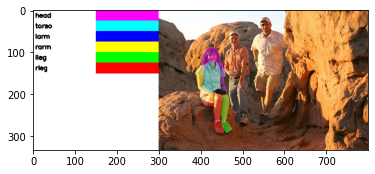

In [16]:
if pdset:
    show_rand_img(pdset, "person", imgid)

### Check wholes parts connection

In [17]:
coco = Parts2WholesDataset(CocoDataset(wholes_path, parts_path))

loading annotations into memory...
Loading json: /data/dataset/pascal/pascalparts_person/annotations/val_wholes_subset.json
Done 0.10s
creating index...
index created!
loading annotations into memory...
Loading json: /data/dataset/pascal/pascalparts_person/annotations/val_parts_subset.json
Done 0.01s
creating index...
index created!


### Coco structure

In [18]:
print(f"cat: {coco.cats[1].keys()}")
print(f"whole ann: {coco.load_anninfos([1], from_gt=True)[0].keys()}")
print(f"part ann: {coco.load_anninfos([1], from_gt=False)[0].keys()}")
print(f"whole img: {coco.load_imginfos([1], from_gt=True)[0].keys()}")
print(f"whole img: {coco.load_imginfos([1], from_gt=False)[0].keys()}")

cat: dict_keys(['id', 'name', 'supercategory', 'is_whole', 'has_parts'])

whole ann: dict_keys(['id', 'image_id', 'category_id', 'segmentation', 'area', 'bbox', 
'iscrowd', 'spawn_id', 'is_occluded', 'occluders'])

part ann: dict_keys(['id', 'image_id', 'category_id', 'segmentation', 'area', 'bbox', 
'iscrowd', 'spawn_id', 'is_occluded', 'occluders'])

whole img: dict_keys(['id', 'width', 'height', 'file_name', 'license', 'flickr_url', 
'coco_url', 'date_captured', 'image_url', 'dataset'])

whole img: dict_keys(['id', 'width', 'height', 'file_name', 'license', 'flickr_url', 
'coco_url', 'date_captured', 'image_url', 'dataset'])

In [19]:
# Get all catids
supercats = ["bicycle", "motorbike", "train", "bottle"]#["aeroplane", "bicycle", "bus", "car", "motorbike", "train", "bottle"]
catids = coco.get_catids(supercats=supercats)
print(catids)

[]

In [20]:
catids = coco.get_wholecat_ids(supercats)
print(catids)

[]

In [21]:
wholes = coco.get_wholes(14404)